# Case DS - Grupo Boticário

## 1. Importação dos pacotes e funções

### 1.1 Bibliotecas utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from IPython.display import display
from pandas.plotting import autocorrelation_plot
import warnings
import datetime

### 1.2 Configurações

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
sns.set_palette("gist_ncar")
sns.set_style("whitegrid")

In [3]:
def plot_ratio_horizontal(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        y = p.get_y() + p.get_height() / 2 + 0.12
        x = p.get_x() + p.get_width()
        ax.annotate(percentage, (x, y), size=13)
    plt.show()

In [4]:
# esta função adiciona o valor relativo da categoria num gráfico de barras vertical
def plot_ratio(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.10
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size=13)
    plt.show()

In [5]:
def correlated_columns(df, threshold):
    return (
        df.corr()
        .pipe(
            lambda df1: pd.DataFrame(
                np.tril(df1, k=-1),
                columns=df.columns,
                index=df.columns,
            )
        )
        .stack()
        .rename("kendall")
        .pipe(
            lambda s: s[
                s.abs() > threshold
            ].reset_index()
        )
        .query("level_0 not in level_1")
    )

In [6]:
def fill_categoric_field_with_value(serie):
    names = serie.unique()
    values = list(range(1, names.size + 1))
    
    #a tabela de valores continha um float(nan) mapeado para um valor inteiro. Solução foi mudar na tabela de valores colocando o None
    nan_index = np.where(pd.isna(names))
    if len(nan_index) > 0 and len(nan_index[0]) > 0:
        nan_index = nan_index[0][0]
        values[nan_index] = None
    #else:
        #print("Não encontrou nan em " + str(names))
        
    return serie.replace(names,values)

# 2. Obtenção dos dados 

## 2.1 Importação dos dados

In [7]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("C:/temp/case_ds/case_ds_gdem.sqlite3")
df = pd.read_sql_query("SELECT * from vendas", con)

In [8]:
df.head() # exibindo as primeiras linhas

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
0,6246,201908,anon_S12,anon_S53,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,461.4,240.0
1,6246,201915,anon_S12,anon_S53,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,461.4,240.0
2,6306,201916,anon_S12,anon_S53,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,521.4,240.0
3,6480,201801,anon_S12,anon_S17,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,833.4,528.0
4,6480,201802,anon_S12,anon_S17,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,833.4,564.0


In [9]:
df.tail() # exibindo as últimas linhas

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,FLG_CAMPANHA_MKT_F,PCT_DESCONTO,VL_PRECO,QT_VENDA
52089,501084,202017,anon_S2,anon_S24,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,443.400,NaN
52090,501084,202101,anon_S2,anon_S24,0,0.0,0.5,0.0,0.0,0.0,0.0,20.0,443.400,NaN
52091,502386,202016,anon_S12,anon_S25,1,1.0,1.0,0.0,0.0,0.0,0.0,25.0,647.430,NaN
52092,502386,202017,anon_S12,anon_S25,1,0.0,1.0,0.0,0.0,0.0,0.0,20.0,727.215,NaN
52093,502386,202101,anon_S12,anon_S25,0,0.0,0.5,0.0,0.0,0.0,0.0,20.0,783.450,NaN


In [10]:
print('A base possui', df.shape[0], 'linhas e', df.shape[1], 'variáveis (atributos)')

A base possui 52094 linhas e 14 variáveis (atributos)


# 3. Análise da qualidade dos dados

In [11]:
df.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
COD_MATERIAL,52094.00,270394.54,154650.26,6246.00,141372.00,174702.00,433710.00,502386.00
COD_CICLO,52094.00,201912.80,85.83,201801.00,201814.00,201910.00,202006.00,202101.00
FLG_DATA,52094.00,0.29,0.45,0.00,0.00,0.00,1.00,1.00
FLG_CAMPANHA_MKT_A,52094.00,0.02,0.12,0.00,0.00,0.00,0.00,1.00
FLG_CAMPANHA_MKT_B,52094.00,0.24,0.40,0.00,0.00,0.00,0.50,1.00
FLG_CAMPANHA_MKT_C,52094.00,0.04,0.19,0.00,0.00,0.00,0.00,1.00
FLG_CAMPANHA_MKT_D,52094.00,0.06,0.17,0.00,0.00,0.00,0.00,1.00
FLG_CAMPANHA_MKT_E,52094.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
FLG_CAMPANHA_MKT_F,52094.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PCT_DESCONTO,16780.00,19.46,77.70,0.00,15.00,20.00,25.04,10000.00


In [12]:
df_zeros = (df == 0).mean()
df_zeros = df_zeros[df_zeros > 0] * 100
print("Colunas com valores zero (qtd relativa): \n\n{}\n".format(df_zeros.sort_values(ascending = False)))

Colunas com valores zero (qtd relativa): 

FLG_CAMPANHA_MKT_E    100.000000
FLG_CAMPANHA_MKT_F    100.000000
FLG_CAMPANHA_MKT_A     98.448958
FLG_CAMPANHA_MKT_C     95.995700
FLG_CAMPANHA_MKT_D     87.516797
FLG_CAMPANHA_MKT_B     72.948900
FLG_DATA               70.979383
PCT_DESCONTO            4.226974
dtype: float64



## 3.1 Tipos dos dados

In [13]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52094 entries, 0 to 52093
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   COD_MATERIAL            52094 non-null  int64  
 1   COD_CICLO               52094 non-null  int64  
 2   DES_CATEGORIA_MATERIAL  52094 non-null  object 
 3   DES_MARCA_MATERIAL      52094 non-null  object 
 4   FLG_DATA                52094 non-null  int64  
 5   FLG_CAMPANHA_MKT_A      52094 non-null  float64
 6   FLG_CAMPANHA_MKT_B      52094 non-null  float64
 7   FLG_CAMPANHA_MKT_C      52094 non-null  float64
 8   FLG_CAMPANHA_MKT_D      52094 non-null  float64
 9   FLG_CAMPANHA_MKT_E      52094 non-null  float64
 10  FLG_CAMPANHA_MKT_F      52094 non-null  float64
 11  PCT_DESCONTO            16780 non-null  float64
 12  VL_PRECO                52088 non-null  float64
 13  QT_VENDA                48946 non-null  float64
dtypes: float64(9), int64(3), object(2)
mem

## 3.2 Valores únicos por variável

In [14]:
pd.options.display.max_rows = 118
print('Valores únicos em cada variável: \n')
df.nunique(dropna=False).sort_values()

Valores únicos em cada variável: 



FLG_CAMPANHA_MKT_E            1
FLG_CAMPANHA_MKT_F            1
FLG_DATA                      2
FLG_CAMPANHA_MKT_C            4
DES_CATEGORIA_MATERIAL        6
FLG_CAMPANHA_MKT_A            6
FLG_CAMPANHA_MKT_B            7
FLG_CAMPANHA_MKT_D            7
COD_CICLO                    53
DES_MARCA_MATERIAL           85
PCT_DESCONTO                786
COD_MATERIAL               2252
QT_VENDA                  14267
VL_PRECO                  15718
dtype: int64

In [15]:
df['DES_MARCA_MATERIAL'].unique()

array(['anon_S53', 'anon_S17', 'anon_S85', 'anon_S61', 'anon_S41',
       'anon_S45', 'anon_S42', 'anon_S67', 'anon_S39', 'anon_S76',
       'anon_S37', 'anon_S47', 'anon_S87', 'anon_S16', 'anon_S63',
       'anon_S15', 'anon_S3', 'anon_S27', 'anon_S84', 'anon_S22',
       'anon_S71', 'anon_S91', 'anon_S55', 'anon_S31', 'anon_S78',
       'anon_S73', 'anon_S29', 'anon_S44', 'anon_S68', 'anon_S64',
       'anon_S92', 'anon_S43', 'anon_S56', 'anon_S72', 'anon_S77',
       'anon_S48', 'anon_S49', 'anon_S86', 'anon_S59', 'anon_S36',
       'anon_S62', 'anon_S94', 'anon_S9', 'anon_S89', 'anon_S28',
       'anon_S38', 'anon_S60', 'anon_S14', 'anon_S23', 'anon_S75',
       'anon_S90', 'anon_S57', 'anon_S69', 'anon_S8', 'anon_S20',
       'anon_S93', 'anon_S83', 'anon_S4', 'anon_S19', 'anon_S34',
       'anon_S80', 'anon_S82', 'anon_S79', 'anon_S74', 'anon_S70',
       'anon_S66', 'anon_S6', 'anon_S58', 'anon_S52', 'anon_S65',
       'anon_S24', 'anon_S54', 'anon_S13', 'anon_S40', 'anon_S25',


In [16]:
df['COD_MATERIAL'].unique()

array([  6246,   6306,   6480, ..., 501060, 501084, 502386], dtype=int64)

In [17]:
df['DES_CATEGORIA_MATERIAL'] = fill_categoric_field_with_value(df['DES_CATEGORIA_MATERIAL'])
df['DES_MARCA_MATERIAL'] = fill_categoric_field_with_value(df['DES_MARCA_MATERIAL'])

In [18]:
df['DES_MARCA_MATERIAL'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85],
      dtype=int64)

In [19]:
df['DES_CATEGORIA_MATERIAL'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

### 3.2.1 Análise do campo COD_CICLO

In [20]:
df['COD_CICLO'].unique()

array([201908, 201915, 201916, 201801, 201802, 201803, 201804, 201805,
       201806, 201807, 201808, 201809, 201810, 201811, 201813, 201902,
       201904, 201914, 202002, 202101, 201812, 201903, 201910, 201913,
       202003, 202008, 202011, 202016, 201917, 202015, 201817, 201901,
       201912, 201818, 201907, 201911, 201814, 201905, 202001, 202004,
       202005, 202006, 202007, 202009, 202010, 202012, 202013, 202017,
       201906, 201815, 201816, 201909, 202014], dtype=int64)

In [21]:
df['CICLO'] = df['COD_CICLO'].astype(str).str.slice(start=4).astype(int)

In [22]:
df['ANO'] = df['COD_CICLO'].astype(str).str.slice(stop=4).astype(int)

In [23]:
df['CICLO'].unique()

array([ 8, 15, 16,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 13, 14, 12, 17,
       18])

In [24]:
df['ANO'].unique()

array([2019, 2018, 2020, 2021])

In [25]:
aux=df.groupby('ANO')['CICLO'].idxmax()
df_tamanho_ciclos = df.loc[aux][['ANO','CICLO']]
df_tamanho_ciclos.head()

,ANO,CICLO
59,2018,18
49,2019,17
114,2020,17
29,2021,1


#### 3.2.1.1 Análise da disponibilidade de informações por produto (Quantidade de ciclos que cada produto aparece)

In [26]:
print('\n**** Valores únicos para cada coluna relacionada com o produto ****')
aux = df['COD_MATERIAL'].unique()
print('Valores unicos para COD_MATERIAL=' + str(aux.shape[0]))
aux = df['DES_MARCA_MATERIAL'].unique()
print('Valores unicos para DES_MARCA_MATERIAL=' + str(aux.shape[0]))
aux = df['DES_CATEGORIA_MATERIAL'].unique()
print('Valores unicos para DES_CATEGORIA_MATERIAL=' + str(aux.shape[0]))

print('\n**** Dados estatísticos para a quantidade de ciclos por COD_MATERIAL ****')

aux_cod = df.groupby(['COD_MATERIAL']).agg({'COD_CICLO' : 'count'}).reset_index()
# aux_cod = aux_cod.groupby(['COD_CICLO']).agg({'COD_MATERIAL' : 'count'}).reset_index()
print(aux_cod['COD_CICLO'].describe())

print('\n**** Dados estatísticos para a quantidade de ciclos por DES_MARCA_MATERIAL ****')
aux_marca = df.groupby(['DES_MARCA_MATERIAL']).agg({'COD_CICLO' : 'count'}).reset_index()
# aux_marca = aux_marca.groupby(['COD_CICLO']).agg({'DES_MARCA_MATERIAL' : 'count'}).reset_index()
print(aux_marca['COD_CICLO'].describe())

print('\n**** Dados estatísticos para a quantidade de ciclos por DES_CATEGORIA_MATERIAL ****')
aux_categoria = df.groupby(['DES_CATEGORIA_MATERIAL']).agg({'COD_CICLO' : 'count'}).reset_index()
# aux_categoria = aux_categoria.groupby(['COD_CICLO']).agg({'DES_CATEGORIA_MATERIAL' : 'count'}).reset_index()
print(aux_categoria['COD_CICLO'].describe())


**** Valores únicos para cada coluna relacionada com o produto ****
Valores unicos para COD_MATERIAL=2252
Valores unicos para DES_MARCA_MATERIAL=85
Valores unicos para DES_CATEGORIA_MATERIAL=6

**** Dados estatísticos para a quantidade de ciclos por COD_MATERIAL ****
count    2252.000000
mean       23.132327
std        19.235714
min         1.000000
25%         4.000000
50%        20.000000
75%        41.000000
max        53.000000
Name: COD_CICLO, dtype: float64

**** Dados estatísticos para a quantidade de ciclos por DES_MARCA_MATERIAL ****
count       85.000000
mean       612.870588
std       1529.509459
min          1.000000
25%          6.000000
50%         36.000000
75%        417.000000
max      10302.000000
Name: COD_CICLO, dtype: float64

**** Dados estatísticos para a quantidade de ciclos por DES_CATEGORIA_MATERIAL ****
count        6.000000
mean      8682.333333
std       5276.979616
min       2205.000000
25%       4094.500000
50%       9923.000000
75%      12859.500000
max

<AxesSubplot:title={'center':'Categoria Material'}, xlabel='Número de Ciclos', ylabel='Quantidade de Categorias'>

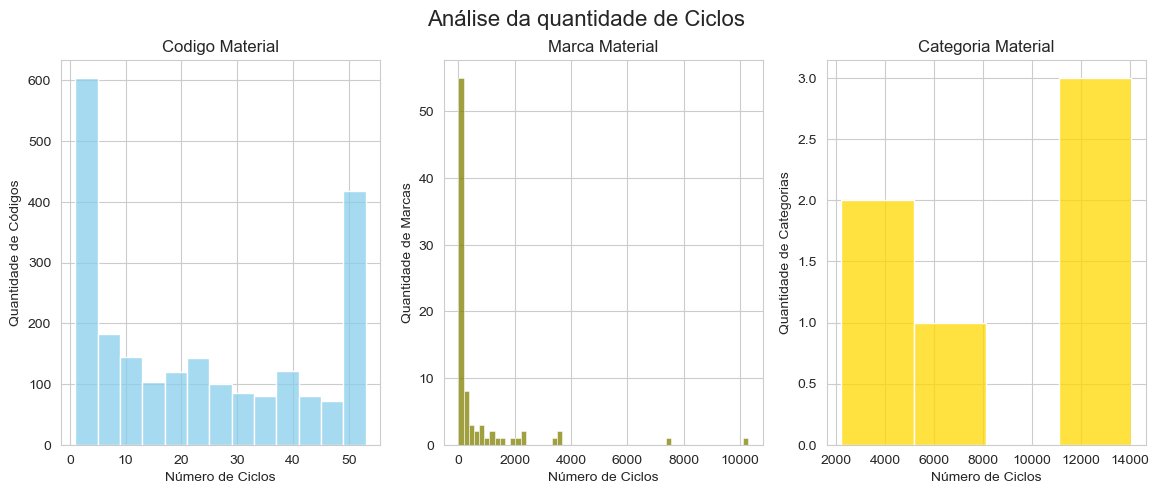

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle('Análise da quantidade de Ciclos', fontsize=16)
axs[0].set_title('Codigo Material')
axs[0].set_ylabel('Quantidade de Códigos')
axs[0].set_xlabel('Número de Ciclos')
axs[1].set_title('Marca Material')
axs[1].set_ylabel('Quantidade de Marcas')
axs[1].set_xlabel('Número de Ciclos')
axs[2].set_title('Categoria Material')
axs[2].set_ylabel('Quantidade de Categorias')
axs[2].set_xlabel('Número de Ciclos')
sns.histplot(data=aux_cod, x='COD_CICLO',color="skyblue", ax=axs[0])
sns.histplot(data=aux_marca, x='COD_CICLO',color="olive", ax=axs[1])
sns.histplot(data=aux_categoria, x='COD_CICLO',color="gold",ax=axs[2])

## 3.2.2 Análise das FLAGs de campanhas

#### Flags deveriam ter exatamente dois valores : 0 e 1.   

In [28]:
print(df['FLG_CAMPANHA_MKT_A'].unique())
print(df['FLG_CAMPANHA_MKT_B'].unique())
print(df['FLG_CAMPANHA_MKT_C'].unique())
print(df['FLG_CAMPANHA_MKT_D'].unique())
print(df['FLG_CAMPANHA_MKT_E'].unique())
print(df['FLG_CAMPANHA_MKT_F'].unique())
print(df['FLG_DATA'].unique())

[0.         1.         0.66666667 0.5        0.33333333 0.25      ]
[0.         1.         0.5        0.25       0.33333333 0.66666667
 0.75      ]
[0.         1.         0.5        0.66666667]
[0.         0.5        0.25       0.33333333 0.66666667 1.
 0.75      ]
[0.]
[0.]
[1 0]


#### Flags E e F somente Nulo, não acrescentariam informações nenhuma ao modelo, podem ser retiradas.

In [29]:
df.drop(['FLG_CAMPANHA_MKT_E' , 'FLG_CAMPANHA_MKT_F'],axis = 1,inplace=True)

#### Flags A, B, C e D possuem valores diferentes de 0 e 1
#### FLG_CAMPANHA_MKT_A

FLG_CAMPANHA_MKT_A
0.000000    51286
0.250000        1
0.333333        7
0.500000       18
0.666667        2
1.000000      780
dtype: int64


<AxesSubplot:xlabel='FLG_CAMPANHA_MKT_A', ylabel='count'>

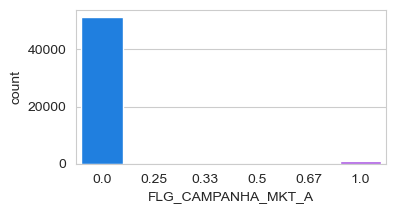

In [30]:
print(df.groupby('FLG_CAMPANHA_MKT_A').size())
plt.figure(figsize=(4,2))
sns.countplot(x = df['FLG_CAMPANHA_MKT_A'].round(2))

#### FLG_CAMPANHA_MKT_B

FLG_CAMPANHA_MKT_B
0.000000    38002
0.250000       63
0.333333       32
0.500000     3401
0.666667       35
0.750000       66
1.000000    10495
dtype: int64


<AxesSubplot:xlabel='FLG_CAMPANHA_MKT_B', ylabel='count'>

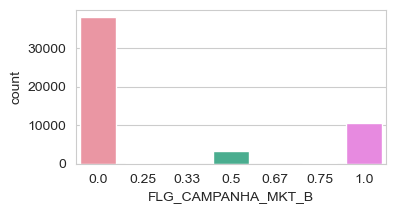

In [31]:
print(df.groupby('FLG_CAMPANHA_MKT_B').size())
plt.figure(figsize=(4,2))
sns.countplot(x = df['FLG_CAMPANHA_MKT_B'].round(2))

#### FLG_CAMPANHA_MKT_C

FLG_CAMPANHA_MKT_C
0.000000    50008
0.500000      128
0.666667        1
1.000000     1957
dtype: int64


<AxesSubplot:xlabel='FLG_CAMPANHA_MKT_C', ylabel='count'>

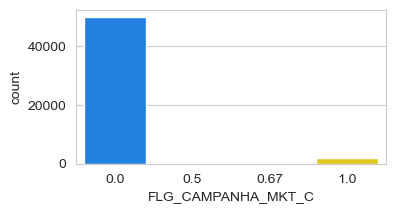

In [32]:
print(df.groupby('FLG_CAMPANHA_MKT_C').size())
plt.figure(figsize=(4,2))
sns.countplot(x = df['FLG_CAMPANHA_MKT_C'].round(2))

#### FLG_CAMPANHA_MKT_D

FLG_CAMPANHA_MKT_D
0.000000    45591
0.250000      409
0.333333       16
0.500000     5954
0.666667       17
0.750000       32
1.000000       75
dtype: int64


<AxesSubplot:xlabel='FLG_CAMPANHA_MKT_D', ylabel='count'>

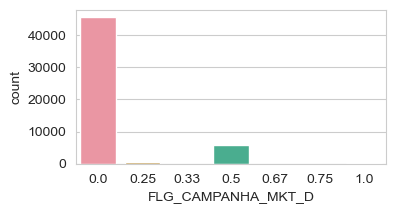

In [33]:
print(df.groupby('FLG_CAMPANHA_MKT_D').size())
plt.figure(figsize=(4,2))
sns.countplot(x = df['FLG_CAMPANHA_MKT_D'].round(2))

#### Explicação 

Como os valores encontrados nas Flags são todos 0, 1/4, 1/3, 1/2, 2/3, 3/4 e 1, entendemos que a flag significaria a fração do tempo do ciclo que a campanha existiu.

## 3.3 Valores ausentes

In [34]:
print(df.isnull().sum())

df_null = df.isnull().mean(axis = 0)
df_null = df_null[df_null > 0] * 100
print("\n Colunas com valores ausentes (qtd relativa): \n\n{}\n".format(df_null.sort_values(axis=0, ascending=False)))

COD_MATERIAL                  0
COD_CICLO                     0
DES_CATEGORIA_MATERIAL        0
DES_MARCA_MATERIAL            0
FLG_DATA                      0
FLG_CAMPANHA_MKT_A            0
FLG_CAMPANHA_MKT_B            0
FLG_CAMPANHA_MKT_C            0
FLG_CAMPANHA_MKT_D            0
PCT_DESCONTO              35314
VL_PRECO                      6
QT_VENDA                   3148
CICLO                         0
ANO                           0
dtype: int64

 Colunas com valores ausentes (qtd relativa): 

PCT_DESCONTO    67.788997
QT_VENDA         6.042922
VL_PRECO         0.011518
dtype: float64



### 3.3.1 Análise coluna VL_PRECO
##### Para o VL_PRECO, por serem somente 6 casos, melhor opção seria retirar as linhas da base.

In [35]:
df.dropna(subset = ['VL_PRECO'], inplace = True ) 

In [36]:
print(df.isnull().sum())

COD_MATERIAL                  0
COD_CICLO                     0
DES_CATEGORIA_MATERIAL        0
DES_MARCA_MATERIAL            0
FLG_DATA                      0
FLG_CAMPANHA_MKT_A            0
FLG_CAMPANHA_MKT_B            0
FLG_CAMPANHA_MKT_C            0
FLG_CAMPANHA_MKT_D            0
PCT_DESCONTO              35308
VL_PRECO                      0
QT_VENDA                   3148
CICLO                         0
ANO                           0
dtype: int64


### 3.3.2 Análise coluna PCT_Desconto

In [37]:
print(df.groupby('PCT_DESCONTO').size())

PCT_DESCONTO
0.0000        2202
0.3330          85
2.5000          29
3.7500           2
5.0000         154
              ... 
33.4900          5
33.7575          2
34.1650          3
35.0000        889
10000.0000       1
Length: 785, dtype: int64


#### Observações:
##### PCT_Desconto, por ser uma porcetagem, não pode existir um desconto acima de 100%.
##### Gerar Modelos e avaliar a eficácia para, onde estiver nulo:
    - colocar 0.0 (opção escolhida)
    - colocar a moda
    - colocar a média

In [38]:
df = df.drop(df[df['PCT_DESCONTO'] > 100].index)

In [39]:
df['PCT_DESCONTO'].fillna(0, inplace=True)

In [40]:
print(df.groupby('PCT_DESCONTO').size())

PCT_DESCONTO
0.0000     37510
0.3330        85
2.5000        29
3.7500         2
5.0000       154
           ...  
33.4800        5
33.4900        5
33.7575        2
34.1650        3
35.0000      889
Length: 784, dtype: int64


In [41]:
df['COD_CICLO'][df['QT_VENDA'].isnull()].unique()

array([202101, 202016, 202017], dtype=int64)

#### todos os nulos da quantidade de vendas são da base a qual devemos prever tal quantidade

## 3.4 Verificação do impacto da pandemia nas Vendas

<AxesSubplot:xlabel='CICLO', ylabel='VENDAS'>

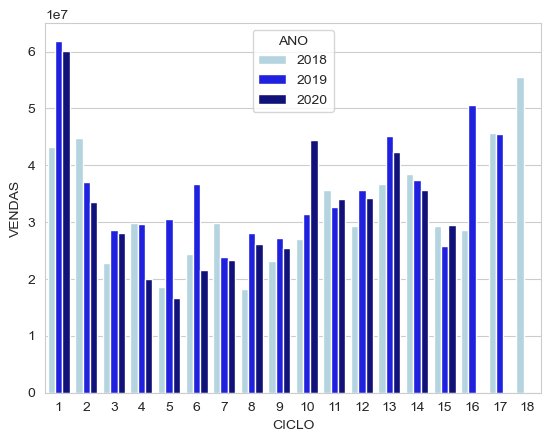

In [42]:
df_18 = df[df['ANO'] == 2018]
df_19 = df[df['ANO'] == 2019]
df_20 = df[df['ANO'] == 2020]

a=df_18.groupby('CICLO')['QT_VENDA'].sum().reset_index(name='VENDAS')
a['ANO'] = 2018
b=df_19.groupby('CICLO')['QT_VENDA'].sum().reset_index(name='VENDAS')
b['ANO'] = 2019
c=df_20.groupby('CICLO')['QT_VENDA'].sum().reset_index(name='VENDAS')
c['ANO'] = 2020

aux = pd.concat([a , b , c])


sns.barplot(data=aux , x='CICLO' , y='VENDAS' , hue='ANO' , palette=["lightblue" , "blue" , "darkblue"])

In [43]:
df_18 = df[df['ANO'] == 2018]
df_19 = df[df['ANO'] == 2019]
df_20 = df[df['ANO'] == 2020]

In [44]:
df_18.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,PCT_DESCONTO,VL_PRECO,QT_VENDA,CICLO,ANO
3,6480,201801,1,2,0,0.0,0.0,0.0,0.0,0.0,833.4,528.0,1,2018
4,6480,201802,1,2,0,0.0,0.0,0.0,0.0,0.0,833.4,564.0,2,2018
5,6480,201803,1,2,0,0.0,0.0,0.0,0.0,0.0,833.4,528.0,3,2018
6,6480,201804,1,2,0,0.0,0.0,0.0,0.0,0.0,833.4,540.0,4,2018
7,6480,201805,1,2,0,0.0,0.0,0.0,0.0,0.0,833.4,522.0,5,2018


In [45]:
df_19.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,PCT_DESCONTO,VL_PRECO,QT_VENDA,CICLO,ANO
0,6246,201908,1,1,1,0.0,0.0,0.0,0.0,0.0,461.4,240.0,8,2019
1,6246,201915,1,1,0,0.0,0.0,0.0,0.0,0.0,461.4,240.0,15,2019
2,6306,201916,1,1,1,0.0,0.0,0.0,0.0,0.0,521.4,240.0,16,2019
15,6480,201902,1,2,0,0.0,0.0,0.0,0.0,0.0,833.4,240.0,2,2019
16,6528,201908,1,3,1,0.0,0.0,0.0,0.0,0.0,403.5,240.0,8,2019


In [46]:
df_20.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,PCT_DESCONTO,VL_PRECO,QT_VENDA,CICLO,ANO
28,7098,202002,1,6,0,0.0,0.0,0.0,0.0,0.0,749.4,240.0,2,2020
44,7230,202003,1,7,0,0.0,0.0,0.0,0.0,0.0,809.4,258.0,3,2020
45,7230,202008,1,7,1,0.0,0.0,0.0,0.0,0.0,809.4,240.0,8,2020
46,7230,202011,1,7,1,0.0,0.0,0.0,0.0,0.0,863.4,246.0,11,2020
47,7230,202016,1,7,1,0.0,0.0,0.0,0.0,0.0,863.4,NaN,16,2020


,CICLO,SOMA
0,1,43248364.0
1,2,44836446.0
2,3,22852518.0
3,4,29890302.0
4,5,18578574.0
5,6,24456567.0
6,7,29815225.0
7,8,18175760.0
8,9,23120448.0
9,10,27061358.0


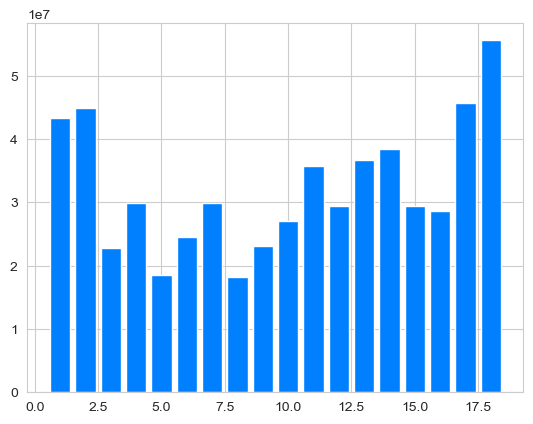

In [47]:
dftes=df_18.groupby('CICLO')['QT_VENDA'].sum().reset_index(name='SOMA')
plt.bar(dftes['CICLO'],dftes['SOMA'])
dftes.head(18)

,CICLO,SOMA
0,1,61897799.0
1,2,37047867.0
2,3,28579331.0
3,4,29743216.0
4,5,30484797.0
5,6,36616381.0
6,7,23942976.0
7,8,28171481.0
8,9,27137576.0
9,10,31407754.0


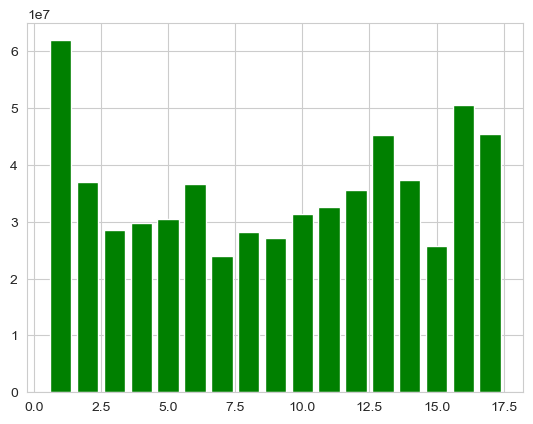

In [48]:
dftes=df_19.groupby('CICLO')['QT_VENDA'].sum().reset_index(name='SOMA')
plt.bar(dftes['CICLO'],dftes['SOMA'],color='green')
dftes.head(18)

,CICLO,SOMA
0,1,60105321.0
1,2,33500887.0
2,3,28048164.0
3,4,20016761.0
4,5,16643963.0
5,6,21638524.0
6,7,23319754.0
7,8,26156431.0
8,9,25450284.0
9,10,44476928.0


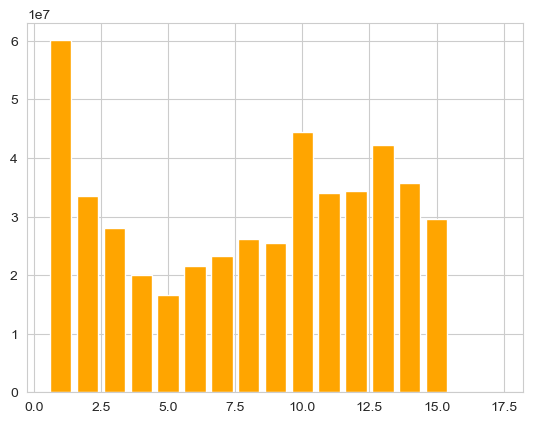

In [49]:
dftes=df_20.groupby('CICLO')['QT_VENDA'].sum().reset_index(name='SOMA')
plt.bar(dftes['CICLO'],dftes['SOMA'], color ='orange')
dftes.head(18)

#### Apesar de ter uma pequena diminuição das vendas em alguns ciclos do ano de 2020, isso se reverte e o ano volta a ter as mesmas características dos anos anteriores. 
#### Consideramos então que a pandemia não teve um impacto muito grande nos dados.

# 4. Criação de variáveis

## 4.1 Criar a variavel de tempo em função do ano e do número de ciclos no ano.
 ### Hipóteses:
   - não existe superposição de ciclos
   - sempre tem um ciclo ativo ao longo do ano.
   - todos os ciclos de um ano tem a mesma duração


In [50]:
a = df.groupby('ANO')['CICLO'].idxmax()
df_tamanho_ciclos = df.loc[a][['ANO', 'CICLO']]

#assumption, 2021 tera 17 ciclos
df_tamanho_ciclos['CICLO'] = df_tamanho_ciclos.apply(lambda x : 17 if x['ANO'] == 2021 else x['CICLO'] , axis = 1)
df_tamanho_ciclos['DELTA'] = 365 / df_tamanho_ciclos['CICLO']

# Pegar o dia de inicio de cada ano e somar os dias de cada ciclo
def obter_data(row , df_tamanho_ciclos):
    ciclo = row['CICLO']
    ano = row['ANO']
    delta = df_tamanho_ciclos.loc[df_tamanho_ciclos['ANO'] == ano]['DELTA'].values[0]
    a_data_inicial = datetime.date(int(ano), 1, 1) + datetime.timedelta(days=(delta * (ciclo - 1)) )
    a_data_final = a_data_inicial + datetime.timedelta(days=delta)
    return a_data_inicial , a_data_final
    
df[['DATA_INICIO' , 'DATA_FIM']] = df.apply(obter_data , df_tamanho_ciclos = df_tamanho_ciclos , result_type='expand' , axis=1)
df.sort_values(by='DATA_INICIO',inplace=True)

In [51]:
df.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,PCT_DESCONTO,VL_PRECO,QT_VENDA,CICLO,ANO,DATA_INICIO,DATA_FIM
18623,153096,201801,1,20,0,0.0,1.0,0.5,0.0,21.640,632.55,442602.0,1,2018,2018-01-01,2018-01-21
8688,124026,201801,1,59,0,0.0,0.0,0.0,0.0,0.000,1488.00,1974.0,1,2018,2018-01-01,2018-01-21
21620,166746,201801,5,48,0,0.0,1.0,0.5,0.0,30.485,461.79,94608.0,1,2018,2018-01-01,2018-01-21
38030,432618,201801,3,54,0,1.0,0.0,0.0,0.0,0.000,461.40,47670.0,1,2018,2018-01-01,2018-01-21
8743,124296,201801,2,40,0,0.0,0.0,0.0,0.0,0.000,413.40,240.0,1,2018,2018-01-01,2018-01-21


# 5. Análise dascolunas após tratamentos

In [52]:
df.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
COD_MATERIAL,52087.00,270427.24,154634.17,6246.00,141372.00,174702.00,433710.00,502386.00
COD_CICLO,52087.00,201912.79,85.83,201801.00,201814.00,201910.00,202006.00,202101.00
DES_CATEGORIA_MATERIAL,52087.00,3.14,1.93,1.00,2.00,2.00,5.00,6.00
DES_MARCA_MATERIAL,52087.00,50.44,21.49,1.00,43.00,54.00,71.00,85.00
FLG_DATA,52087.00,0.29,0.45,0.00,0.00,0.00,1.00,1.00
FLG_CAMPANHA_MKT_A,52087.00,0.02,0.12,0.00,0.00,0.00,0.00,1.00
FLG_CAMPANHA_MKT_B,52087.00,0.24,0.40,0.00,0.00,0.00,0.50,1.00
FLG_CAMPANHA_MKT_C,52087.00,0.04,0.19,0.00,0.00,0.00,0.00,1.00
FLG_CAMPANHA_MKT_D,52087.00,0.06,0.17,0.00,0.00,0.00,0.00,1.00
PCT_DESCONTO,52087.00,6.08,10.48,0.00,0.00,0.00,13.42,35.00


In [53]:
df_zeros = (df == 0).mean()
df_zeros = df_zeros[df_zeros > 0] * 100
print("Colunas com valores zero (qtd relativa): \n\n{}\n".format(df_zeros.sort_values(ascending = False)))

Colunas com valores zero (qtd relativa): 

FLG_CAMPANHA_MKT_A    98.448749
FLG_CAMPANHA_MKT_C    95.995162
FLG_CAMPANHA_MKT_D    87.515119
FLG_CAMPANHA_MKT_B    72.945265
PCT_DESCONTO          72.014130
FLG_DATA              70.977403
dtype: float64



In [54]:
df.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,PCT_DESCONTO,VL_PRECO,QT_VENDA,CICLO,ANO,DATA_INICIO,DATA_FIM
18623,153096,201801,1,20,0,0.0,1.0,0.5,0.0,21.640,632.55,442602.0,1,2018,2018-01-01,2018-01-21
8688,124026,201801,1,59,0,0.0,0.0,0.0,0.0,0.000,1488.00,1974.0,1,2018,2018-01-01,2018-01-21
21620,166746,201801,5,48,0,0.0,1.0,0.5,0.0,30.485,461.79,94608.0,1,2018,2018-01-01,2018-01-21
38030,432618,201801,3,54,0,1.0,0.0,0.0,0.0,0.000,461.40,47670.0,1,2018,2018-01-01,2018-01-21
8743,124296,201801,2,40,0,0.0,0.0,0.0,0.0,0.000,413.40,240.0,1,2018,2018-01-01,2018-01-21


# 6. Análise da correlação das colunas

<AxesSubplot:>

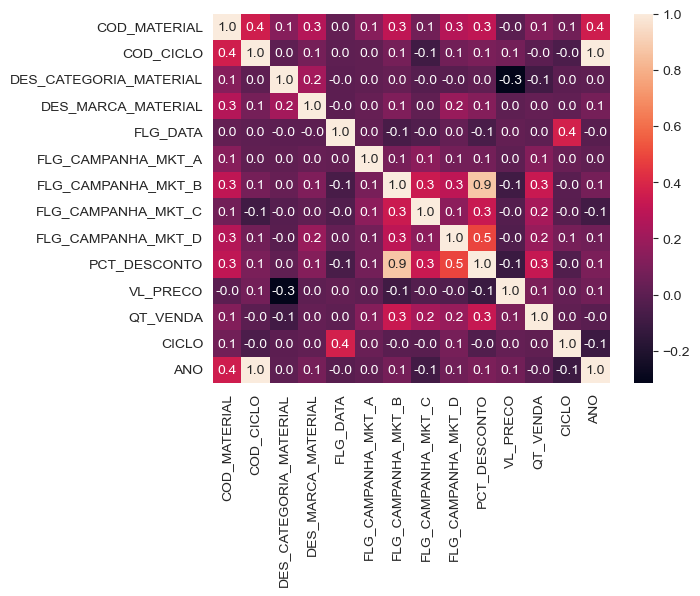

In [55]:
sns.heatmap(df.corr(), annot = True, fmt = ".1f")

#### Não foram observados correlações significativas nos dados.

# 7. Análise Autocorrelação

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

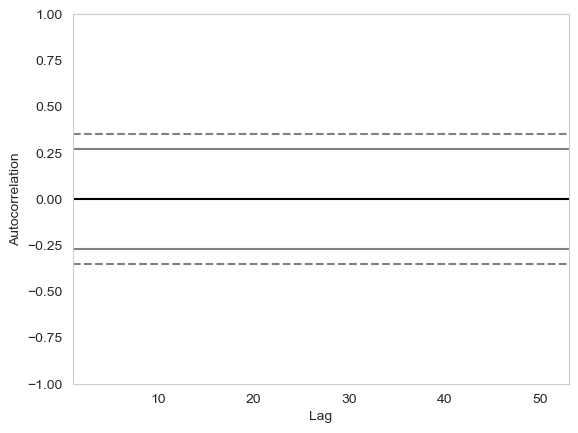

In [56]:
#Cod do produto que tem quantidade completa de ciclos
aux = df.loc[df.COD_MATERIAL == 125556]
autocorrelation_plot(aux['QT_VENDA'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

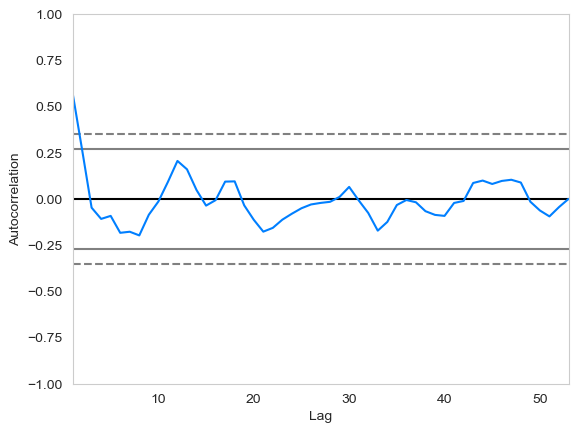

In [57]:
aux_vendas_por_ciclo = df.groupby(['COD_CICLO']).agg({'QT_VENDA' : 'sum'}).reset_index()
autocorrelation_plot(aux_vendas_por_ciclo['QT_VENDA'])

#### Não foi identificado autocorrelação das quantidades de vendas ao longo do tempo tanto para um produto quanto para o somatório das vendas de cada ciclo
    indicando que o valor da quantidade de vendas dos produtos não tem uma correlação direta com os valores de períodos anteriores

# 8. Verificação dados para a previsao

In [58]:
df_a_prever = df[df['QT_VENDA'].isnull()]
df_a_prever.head()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,PCT_DESCONTO,VL_PRECO,QT_VENDA,CICLO,ANO,DATA_INICIO,DATA_FIM
9671,128466,202016,1,58,1,0.0,0.5,0.0,0.0,10.4,944.58,NaN,16,2020,2020-11-18,2020-12-09
1214,61326,202016,1,9,1,0.0,0.0,0.0,0.0,0.0,833.40,NaN,16,2020,2020-11-18,2020-12-09
26389,174816,202016,2,43,1,0.0,0.0,0.0,0.0,0.0,389.40,NaN,16,2020,2020-11-18,2020-12-09
32977,427056,202016,1,49,1,0.0,0.0,0.0,0.0,0.0,808.40,NaN,16,2020,2020-11-18,2020-12-09
47,7230,202016,1,7,1,0.0,0.0,0.0,0.0,0.0,863.40,NaN,16,2020,2020-11-18,2020-12-09


In [59]:
df_a_prever.tail()

,COD_MATERIAL,COD_CICLO,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,PCT_DESCONTO,VL_PRECO,QT_VENDA,CICLO,ANO,DATA_INICIO,DATA_FIM
13157,142764,202101,4,60,0,0.0,0.0,0.0,0.0,0.00,551.400,NaN,1,2021,2021-01-01,2021-01-22
51030,468252,202101,2,55,0,0.0,0.5,0.0,0.0,33.33,385.275,NaN,1,2021,2021-01-01,2021-01-22
47404,451494,202101,1,55,0,0.0,0.5,0.0,0.0,12.00,1253.175,NaN,1,2021,2021-01-01,2021-01-22
47425,451524,202101,6,71,0,0.0,1.0,0.0,0.0,35.00,302.490,NaN,1,2021,2021-01-01,2021-01-22
52093,502386,202101,1,75,0,0.0,0.5,0.0,0.0,20.00,783.450,NaN,1,2021,2021-01-01,2021-01-22


In [60]:
print('A base possui', df_a_prever.shape[0], 'linhas e', df_a_prever.shape[1], 'variáveis (atributos)')

A base possui 3148 linhas e 16 variáveis (atributos)


In [61]:
df_a_prever['COD_CICLO'].unique()

array([202016, 202017, 202101], dtype=int64)

In [62]:
df_a_prever.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3148 entries, 9671 to 52093
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   COD_MATERIAL            3148 non-null   int64  
 1   COD_CICLO               3148 non-null   int64  
 2   DES_CATEGORIA_MATERIAL  3148 non-null   int64  
 3   DES_MARCA_MATERIAL      3148 non-null   int64  
 4   FLG_DATA                3148 non-null   int64  
 5   FLG_CAMPANHA_MKT_A      3148 non-null   float64
 6   FLG_CAMPANHA_MKT_B      3148 non-null   float64
 7   FLG_CAMPANHA_MKT_C      3148 non-null   float64
 8   FLG_CAMPANHA_MKT_D      3148 non-null   float64
 9   PCT_DESCONTO            3148 non-null   float64
 10  VL_PRECO                3148 non-null   float64
 11  QT_VENDA                0 non-null      float64
 12  CICLO                   3148 non-null   int32  
 13  ANO                     3148 non-null   int32  
 14  DATA_INICIO             3148 non-nul

In [63]:
pd.options.display.max_rows = 118
print('Valores únicos em cada variável: \n')
df_a_prever.nunique(dropna=False).sort_values()

Valores únicos em cada variável: 



QT_VENDA                     1
FLG_DATA                     2
ANO                          2
COD_CICLO                    3
FLG_CAMPANHA_MKT_C           3
CICLO                        3
DATA_INICIO                  3
DATA_FIM                     3
FLG_CAMPANHA_MKT_D           4
FLG_CAMPANHA_MKT_A           5
DES_CATEGORIA_MATERIAL       6
FLG_CAMPANHA_MKT_B           6
DES_MARCA_MATERIAL          51
PCT_DESCONTO               153
COD_MATERIAL              1205
VL_PRECO                  1754
dtype: int64

# 9. Análise da ordem de grandeza de quantidade de vendas por produto

In [64]:
df.groupby('COD_MATERIAL').sum('QT_VENDA').mean()

COD_CICLO                 4.670085e+06
DES_CATEGORIA_MATERIAL    7.265364e+01
DES_MARCA_MATERIAL        1.166622e+03
FLG_DATA                  6.712700e+00
FLG_CAMPANHA_MKT_A        3.520944e-01
FLG_CAMPANHA_MKT_B        5.459480e+00
FLG_CAMPANHA_MKT_C        8.977205e-01
FLG_CAMPANHA_MKT_D        1.418702e+00
PCT_DESCONTO              1.405737e+02
VL_PRECO                  1.260540e+04
QT_VENDA                  7.390581e+05
CICLO                     2.100782e+02
ANO                       4.669875e+04
dtype: float64

In [65]:
df.groupby('COD_MATERIAL').sum('QT_VENDA').std()

COD_CICLO                 3.883595e+06
DES_CATEGORIA_MATERIAL    8.440446e+01
DES_MARCA_MATERIAL        1.180594e+03
FLG_DATA                  5.515340e+00
FLG_CAMPANHA_MKT_A        7.149835e-01
FLG_CAMPANHA_MKT_B        7.634384e+00
FLG_CAMPANHA_MKT_C        1.354616e+00
FLG_CAMPANHA_MKT_D        3.286483e+00
PCT_DESCONTO              1.975116e+02
VL_PRECO                  1.284440e+04
QT_VENDA                  2.206402e+06
CICLO                     1.753029e+02
ANO                       3.883421e+04
dtype: float64

In [66]:
df.groupby(['COD_MATERIAL','COD_CICLO']).sum('QT_VENDA').describe()

,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,PCT_DESCONTO,VL_PRECO,QT_VENDA,CICLO,ANO
count,52087.000000,52087.000000,52087.000000,52087.000000,52087.000000,52087.000000,52087.000000,52087.000000,52087.000000,5.208700e+04,52087.000000,52087.000000
mean,3.141206,50.439323,0.290226,0.015223,0.236043,0.038813,0.061338,6.077756,544.999042,3.195344e+04,9.082804,2019.037111
std,1.933942,21.493605,0.453871,0.121914,0.404049,0.191543,0.165139,10.480760,250.927516,9.546286e+04,5.129247,0.862346
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.060000,0.000000e+00,1.000000,2018.000000
25%,2.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,389.400000,5.400000e+02,5.000000,2018.000000
50%,2.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,461.400000,4.314000e+03,9.000000,2019.000000
75%,5.000000,71.000000,1.000000,0.000000,0.500000,0.000000,0.000000,13.420000,593.400000,2.742600e+04,14.000000,2020.000000
max,6.000000,85.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,5539.620000,4.047372e+06,18.000000,2021.000000


### Vimos que a média da quantitade de vendas por produto é de 32 mil, porém o desvio padrão é de 95

# Conclusões da análise exploratoria
### Colunas FLG_CAMPANHA_MKT_E e FLG_CAMPANHA_MKT_F podem ser retiradas
### Retirar casos onde o VL_PRECO for nulo (somente 6 casos)
### Retirar PCT_Desconto que for maior que 100
### Separar couna COD_CICLO, em ano e ciclo.
### Criação das colunas de Data_inicio e Data_fim do ciclo
### Analisar o que fazer com a PCT_DESCONTO que estiver nulo (34197 casos):
#### - colocar 0.0 (escolhido)
#### - colocar a moda
#### - colocar a média
